# ASSIGNMENT 3 

#### Machine Learning in Korea University
#### COSE362, Fall 2018
#### Due : 12/18 (THU) 11:59 PM

#### In this assignment, you will implement and train a Recommender System. Also, you will learn how to utilize scikit-learn to analyze data using clustering.
* Implemented using Anaconda 5.3 with python 3.7. Please use <b>python 3</b>
* Use given dataset. Please do not change data split.
* Use numpy, scikit-learn, and matplotlib library
* You don't have to use all imported packages below. (some are optional). <br>
* <b>*DO NOT MODIFY OTHER PARTS OF CODES EXCEPT "Your Code Here"*</b>


### 1. Recommender System

In the problem 1, you will implement a simple recommender system.
* See your lecture note (Lecture 15. Recommender Systems - Collaborative filtering). 
* Do not implement matrix factorization and Do not import any other packages and libraries. <b>You should use only numpy</b>.
* Analyze train and validation error. <br>

### Dataset description : MovieLens Dataset


Here are brief descriptions of the data.

><b>u.data</b>     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC

><b>u1.base</b> -- Subset of u.data. You should use u1.base at training time. <br>
><b>u1.test</b> -- Subset of u.data. You should use u1.test at testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)

In [2]:
with open('./data/u.info') as f:
    info = f.readlines()
    num_users = int(info[0].split()[0]) # 943
    num_movies = int(info[1].split()[0]) # 1682

def read_data(file_name):
    with open('./data/' + file_name) as f:
        dataset = []
        cnt = 0
        while True:
            line = f.readline()
            if not line: break
            d = list(map(int, line.split()[:3]))
            d[0] -= 1
            d[1] -= 1
            dataset.append(d)
    return dataset

###########################################

train_dataset = read_data('u1.base')
valid_dataset = read_data('u1.test')

### 1 - (1) Design your recommender system model.

##### Instructions <br>
* <b>\__init\__</b> : configure model. <b>DO NOT MODIFY</b>.
* <b>compute_loss</b> : compute loss between user i and movie j.
* <b>update</b> : update the parameter of user i and movie j with gradient descent.
* <b>run_epoch</b> : train one iteration of collaborative filtering. <b>If "trainable=False", this function doesn't update parameters.</b> <br>
<t>The variable "trainable" is false when the model is on validation or test.
    

<br>* <b>loss</b> --> see your lecture note.
<br>* <b>rmse</b> indicates Root Mean Square Error that is widely used for rating prediction evaluation.

In [3]:
class RecommenderSystem():
    def __init__(self, num_users, num_movies, user_size, movie_size, learning_rate, reg_coef):
        self.user_mat = np.random.normal(0, 1, (num_users, user_size)) # theta
        self.movie_mat = np.random.normal(0, 1, (num_movies, movie_size)) ## x
        self.learning_rate = learning_rate
        self.reg_coef = reg_coef
        self.loss = 0.0
    
    def compute_loss(self, i, j, rating):
        # Your Code Here
        reg_user, reg_movie = 0, 0
        for k in range(len(self.user_mat[j])):
            reg_movie += (self.movie_mat[i][k])**2
            reg_user += (self.user_mat[j][k])**2
            
        target = np.dot(self.user_mat[j], self.movie_mat[i])
        loss = 1/2 * (target - rating)**2 + self.reg_coef/2 * (reg_movie) + self.reg_coef/2 * (reg_user)
        # End Your Code
        return target, loss
        
    def update(self, target, i, j, rating):
        # Your Code Here
        for k in range(len(self.user_mat[j])):
            self.movie_mat[i][k] -= self.learning_rate * (self.user_mat[j][k] * (target - rating)
                                                          + self.reg_coef * self.movie_mat[i][k])
            self.user_mat[j][k] -= self.learning_rate * (self.movie_mat[i][k] * (target - rating)
                                                        + self.reg_coef * self.user_mat[j][k])
        # End Your Code

    def run_epoch(self, dataset, trainable=False):
        loss_sum = rmse_sum = target_sum = 0
        np.random.shuffle(dataset)
        for s_idx, sample in enumerate(dataset):
        # Your Code Here
            jth_user = sample[0] # user number
            ith_movie = sample[1] # movie number
            y_ij = sample[2]
            
            target, loss = self.compute_loss(ith_movie, jth_user, y_ij)
            
            rmse_sum += (target - y_ij)**2 # sum of mean squared error
            loss_sum += loss
            
            if trainable == True:
                self.update(target, ith_movie, jth_user, y_ij)
                
        rmse = np.sqrt(rmse_sum / len(dataset))
        # End Your Code
        return loss_sum / len(dataset), rmse

In [4]:
def main(config):
    #####
    # optimal : (int) the epoch where validation loss is minimum
    # eps : (list) a list of training epochs
    # loss_tr : (list) a list of training losses
    # loss_va : (list) a list of validation losses
    # rmse_tr : (list) a list of training rmse(root mean square error)
    # rmse_va : (list) a list of validation rmse(root mean square error)
    
    model = RecommenderSystem(num_users, num_movies,
                            config['user_size'],
                             config['movie_size'],
                             config['learning_rate'],
                             config['reg_coef'])
    
    min_loss = optimal = 99999
    eps, loss_tr, loss_va, rmse_tr, rmse_va  = [], [], [], [], []
    for epoch in range(config['max_epoch']):
        # ls_tr : mean of total losses in an epoch
        # e_tr : mean of total root mean square errors in an epoch
        ls_tr, e_tr = model.run_epoch(train_dataset, trainable=True)
        ls_va, e_va = model.run_epoch(valid_dataset, trainable=False)
        
        # Your Code Here
        loss_tr.append(ls_tr)
        loss_va.append(ls_va)
        
        rmse_tr.append(e_tr)
        rmse_va.append(e_va)
        
        eps.append(epoch)
        
        if ls_va < min_loss:
            min_loss = ls_va
            optimal = epoch
        # End Your Code
        
    return optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model

###################################################################

config = {'user_size': 10,
         'movie_size': 10,
         'learning_rate': 0.01,
         'reg_coef': 0.001,
         'max_epoch': 50,
         'eval_step': 5}

optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model = main(config)
print ("[Exp have been finished !]\nOptimal : {}, Train loss : {:2.3f}, Valid loss : {:2.3f}, RMSE : {:3.2f}"
       .format(optimal, loss_tr[optimal], loss_va[optimal], rmse_va[optimal]))

[Exp have been finished !]
Optimal : 26, Train loss : 0.347, Valid loss : 0.676, RMSE : 1.16


### 1 - (2) Plot the training and validation loss against epochs and Analyze.
 


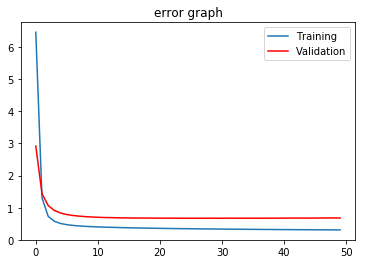

In [5]:
# Plot your train error and validation error by number of iterations.
plt.plot(eps, loss_tr, eps, loss_va, 'r-')
plt.title("error graph")
plt.legend(["Training", "Validation"])
plt.show()

##### Analyze the result.

본 과제는 공지사항의 힌트를 참고하여 update 함수에서 movie와 user feature를 특정 row만 update하도록 구현하여 run_epoch 함수에서 전체 데이터에 대해 연산을 하도록 하였다. 그 결과, movie와 user의 feature matrix의 feature 수를 10개로 설정하였을 때, training과 validation error는 위의 그래프와 같다. validation error가 가장 작은 epoch은 27번째였으며, rmse값은 1.14였다. 전체 데이터 셋에 대하여 user, movie feature matrix를 fitting함에 따라, 약 5번째 epoch 이후부터 converge되는 것을 알 수 있었다.

## 2. Clustering

In the problem 2, you would learn how to analyze data with unsupervised learning algorithm.
* Implement <b>k-means clustering</b> algorithm using <b>scikit-learn packages</b>. <br>
* Visualize your result and analyze. <br>
* Implement <b>PCA(principle component analysis)</b> and visualize your data onto 2-dimensional domain, and visualize your data by class-labels.

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import cluster
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# 가상의 데이터 생성
n_samples = 3000
random_state = 1182
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

### 2 - (1) Implement K-means clustering algorithm and visualize data with class labels.
For given data, find the best number of clusters (each cluster is well-divided). <br>
Visualize your results using <b>scatter plot</b>. 

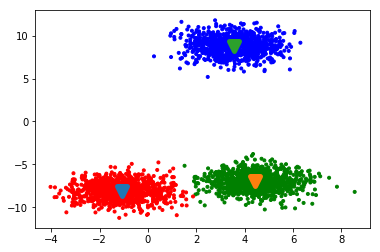

In [7]:
# Use sklearn.cluster.KMeans for k-means clustering
# Use plt.scatter for visualization

# Your Code Here
LABEL_COLOR_MAP = {0: 'r', 1: 'g', 2: 'b'}

model = KMeans(init='random', n_clusters=3).fit(X) # optimal number of clusters => 3
centroids = model.cluster_centers_
label_color = [LABEL_COLOR_MAP[l] for l in model.labels_]

plt.scatter(x=X[:, 0], y=X[:, 1], marker='.', c=label_color)
for ctd in centroids:
    plt.scatter(ctd[0], ctd[1], marker='v', s=100, linewidths=5, zorder=5)
# End Your Code

### 2 - (2) Implement PCA and visualize data with class labels.
Conduct K-means clustering on given data. <br>
Implement <b>PCA(principle component analysis)</b> to convert high-dimensional vectors into 2-dimensional vectors. <br>
Compare plots by K-means result and class labels by visualization. <br>
* Dataset : Handwritten digit dataset (Class : digit, Data : digit image)
* Visualize <b>two scatter plots</b>. (One for class label and one for k-means clustering)

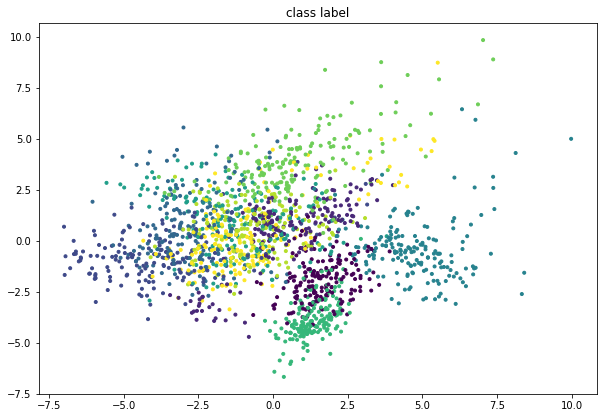

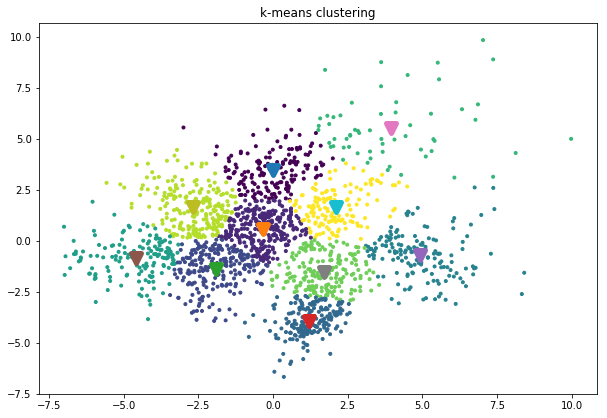

In [8]:
# use sklearn.decomposition.PCA
digits = load_digits()
data = scale(digits.data)
labels = digits.target

# Your Code Here
target_num = len(digits['target_names']) # 10개
reduced_data = PCA(n_components=2).fit_transform(data) # feature reduction(64->2)

'''K-means clustering plot'''
model = KMeans(init='random', n_clusters=target_num).fit(reduced_data)

LABEL_COLOR_MAP = {idx:label for idx, label in enumerate(set(labels))}
label_color= [LABEL_COLOR_MAP[l] for l in model.labels_] # 숫자 인덱스 : 0~9

centroids= model.cluster_centers_

plt.rcParams["figure.figsize"] = (10, 15)
plt.subplot(211)
plt.title('class label')
plt.scatter(x=reduced_data[:,0], y=reduced_data[:, 1], marker='.', c = labels)
plt.figure()

plt.subplot(212)
plt.title("k-means clustering")
plt.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], marker='.', c=label_color, label=labels)
for ctd in centroids:
    plt.scatter(ctd[0], ctd[1], marker='v', s=100, linewidths=5, zorder=5)
# End Your Code